# UFP Demo with JAX-MD

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Robert-Schmid/uf3/blob/jax/examples/jax-md/jax-md-ufp-demo.ipynb)

In [ ]:
#@title install UF3
!git clone -b jax https://github.com/Robert-Schmid/uf3.git
%cd /content/uf3
!pip install -r requirements.txt
!pip install -e .
%cd /content/uf3/examples/jax-md

In [2]:
#@title JAX-MD Imports & Utils from the Cutom Potentials notebook from git:google/jax-md
!pip install -q git+https://www.github.com/google/jax-md

import numpy as onp

import jax.numpy as jnp
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util

from functools import partial
import time
from typing import List

f32 = jnp.float32
f64 = jnp.float64
Array = jnp.ndarray

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 2.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 2.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def plot_system(R,box_size,species=None,ms=20):
  R_plt = onp.array(R)

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
  else:
    for ii in range(jnp.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))
  
key = random.PRNGKey(0)

## Importing potentials

We import the parameters from the 2-body ufp potentials trained on tungsten data in the pair_potential_demo notebook from the examples.

In [3]:
from uf3.representation import bspline
from uf3.data import composition
from uf3.regression import least_squares

element_list = ['W']
degree = 2

chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)

r_min_map = {('W', 'W'): 1.5,
            }
r_max_map = {('W', 'W'): 5.5,
            }
resolution_map = {('W', 'W'): 25,
                 }
trailing_trim = 3

bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)

model = least_squares.WeightedLinearModel(bspline_config)

model.load(filename="../tungsten_extxyz/model_pair.json")

In [4]:
coefficients = jnp.asarray(model.coefficients[1:])
knots = jnp.asarray(model.bspline_config.knots_map[('W','W')])

print(coefficients)
print(knots)

[ 6.43001157e+00  5.97354258e+00  5.06058796e+00  3.69113106e+00
  1.65205855e+00  9.23859147e-01  2.81258202e-01 -5.36413561e-03
 -1.65669972e-01 -2.39954884e-01 -2.77954263e-01 -2.80998799e-01
 -2.49653066e-01 -1.77409590e-01 -1.00099852e-01 -6.82599769e-02
 -2.00034440e-02 -3.28071234e-02 -3.43219435e-02 -3.43618259e-02
 -2.88400639e-02 -2.12175439e-02 -6.90983500e-04 -9.25139031e-03
 -8.08694792e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[1.5  1.5  1.5  1.5  1.66 1.82 1.98 2.14 2.3  2.46 2.62 2.78 2.94 3.1
 3.26 3.42 3.58 3.74 3.9  4.06 4.22 4.38 4.54 4.7  4.86 5.02 5.18 5.34
 5.5  5.5  5.5  5.5 ]


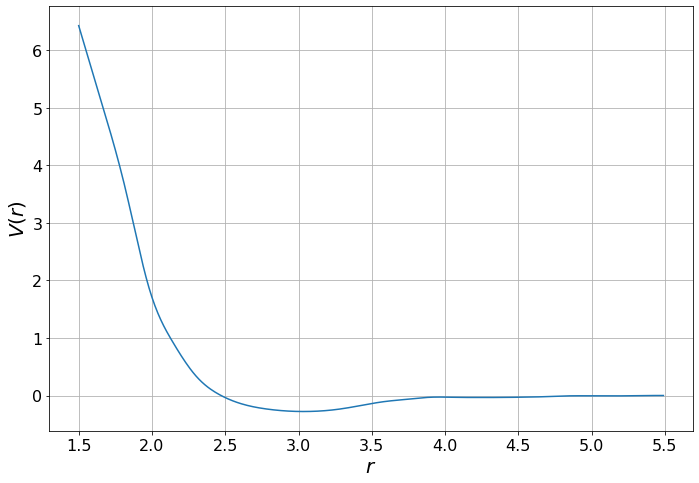

In [5]:
from uf3.jax.potentials import uf2_interaction

drs = jnp.arange(1.5,5.5,0.01)
U = uf2_interaction(drs, coefficients=coefficients, knots=knots, cutoff=5.5)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()

## Using the potential

### Creating a system

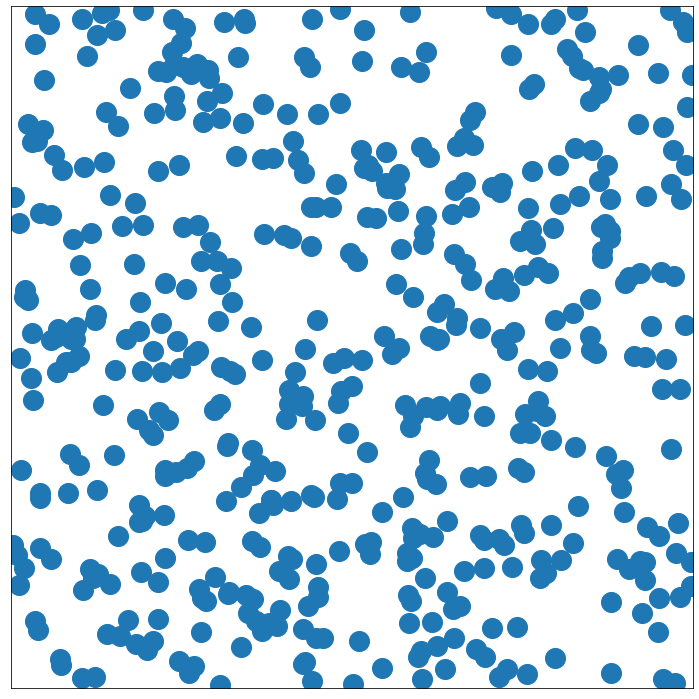

In [6]:
N = 500
dimension = 3
box_size = 12.0

key, split = random.split(key)
R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 

plot_system(R,box_size)

In [7]:
box = jnp.eye(dimension) * box_size
displacement, shift = space.periodic_general(box, fractional_coordinates=False)

### Calculating forces, energies and stress

In [8]:
from uf3.jax.potentials import uf2_pair, get_stress_fn

# Create a function to calculate the total energy with specified parameters
energy_fn = uf2_pair(displacement, coefficients=coefficients, knots=knots)

# Use this to calculate the total energy
print(energy_fn(R))

# Use grad to calculate the net force
force = -grad(energy_fn)(R)
print(force[:5])

4033.100798646419
[[  7.64623469 -10.98462509 -23.73895001]
 [  4.39279262  13.44039394  19.71655208]
 [ 13.82819561 -21.79921483  -5.14190699]
 [ 24.41905083   7.88597327  15.34640167]
 [  1.88079223  -5.52988133  16.91941324]]


In [9]:
stress_fn = get_stress_fn(energy_fn, box)
stress = stress_fn(R)
print(stress)

[[-6.01871806  0.05254257 -0.01569138]
 [ 0.05254257 -6.10154324  0.10966728]
 [-0.01569138  0.10966728 -6.31664028]]


### More derivatives

In [10]:
ener = lambda c: energy_fn(R, coefficients=c)
print(ener(coefficients))

print(grad(ener)(coefficients))

4033.100798646419
[  80.18667359  184.06035033  316.04001647  490.2298231   569.86425275
  658.16960725  754.12424823  861.5019516  1035.36599478 1167.34641746
 1289.49048642 1424.14195878 1550.48454773 1704.94896464 1869.11938022
 2008.97694181 2208.02549203 2397.55218936 2584.83031618 2794.22724524
 2898.8789498  3090.58207582 3351.66114224 3618.73642567 3867.03294737
 3072.65634724 2139.73393779 1092.0313161 ]


## Simple gradient descent with AD

Let's have a look at the lennard-jones potential defined in the JAX-MD package. Can we easily replicate this with our 2-body ufp potential?

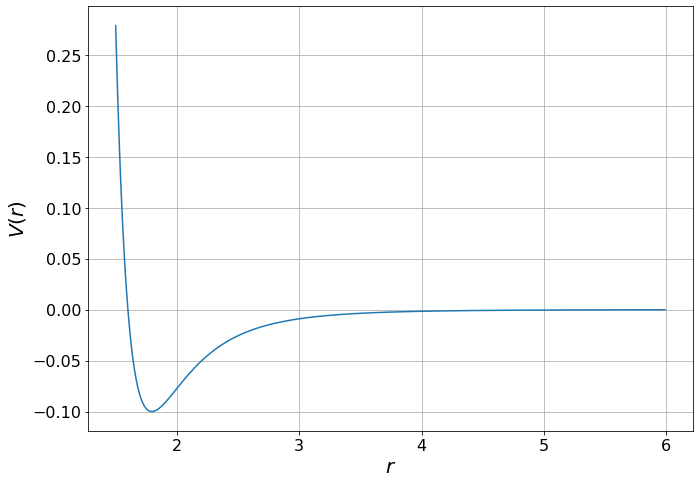

In [11]:
from jax_md.energy import lennard_jones, lennard_jones_pair

drs = jnp.arange(1.5,6.0,0.01)
U = lennard_jones(drs, sigma=1.6, epsilon=0.1)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()

We use the mean squared error as a simple loss function.

In [12]:
drs = jnp.arange(1.5,6.0,0.01)

uf2 = lambda drs, co: uf2_interaction(drs, coefficients=co, knots=knots, cutoff=5.5)
lj = lambda drs: lennard_jones(drs, sigma=1.6, epsilon=0.1)

def error(coefficients, drs):
    return jnp.sum((lj(drs) - uf2(drs, coefficients)) ** 2) / len(drs)

Taking derivatives with respect to the coefficients.

In [13]:
c = jnp.zeros_like(coefficients)

grad(error)(c, drs)

DeviceArray([-3.60189188e-03, -1.05951747e-03,  3.20856193e-03,
              6.42891898e-03,  5.67378975e-03,  4.16310747e-03,
              2.92075879e-03,  2.03636335e-03,  1.43030073e-03,
              1.01724913e-03,  7.33801964e-04,  5.36982505e-04,
              3.98441820e-04,  2.99549094e-04,  2.27983804e-04,
              1.75511323e-04,  1.36558668e-04,  1.07304391e-04,
              8.50935746e-05,  6.80581088e-05,  5.48673678e-05,
              4.45624951e-05,  3.64448900e-05,  3.00002496e-05,
              2.48462159e-05,  1.60606113e-05,  9.57645834e-06,
              3.94039458e-06], dtype=float64)

A simple gradient descent loop without regularization.
This is enough for our simple demonstartion, but can produce 'wobbly' results on some problems.

Error after 0 iterations: 0.0013452790854316297
Error after 10 iterations: 0.0006278917227223323
Error after 20 iterations: 0.000369139153904668
Error after 30 iterations: 0.00024919058019633845
Error after 40 iterations: 0.00017985624357809202
Error after 50 iterations: 0.00013400064471622112
Error after 60 iterations: 0.00010157059537398169
Error after 70 iterations: 7.787351834532241e-05
Error after 80 iterations: 6.024249633131999e-05
Error after 90 iterations: 4.696588792460343e-05


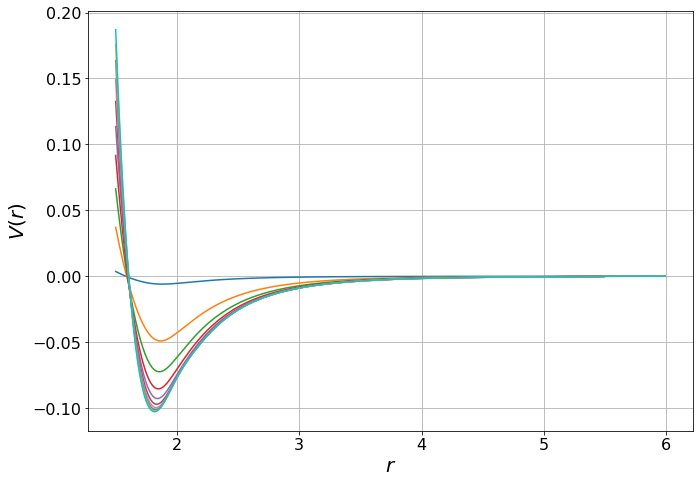

In [14]:
drs = jnp.arange(1.5,6.0,0.01)

c = jnp.zeros_like(coefficients)
loss = jit(grad(error))
error = jit(error)
uf2 = jit(uf2)

for i in range(100):
    dc = loss(c, drs)
    c -= dc

    if i % 10 == 0:
        print(f"Error after {i} iterations: {error(c, drs)}")
        U = uf2(drs, c)
        plt.plot(drs,U)

format_plot(r'$r$', r'$V(r)$')
finalize_plot()

We are quite close to the lennard-jones potential within the knot range (1.5 to 5.5). But the current ufp JAX implementation returns to zero outside the knot range.

Total error on the energies within the knot range: 0.01205017939765968


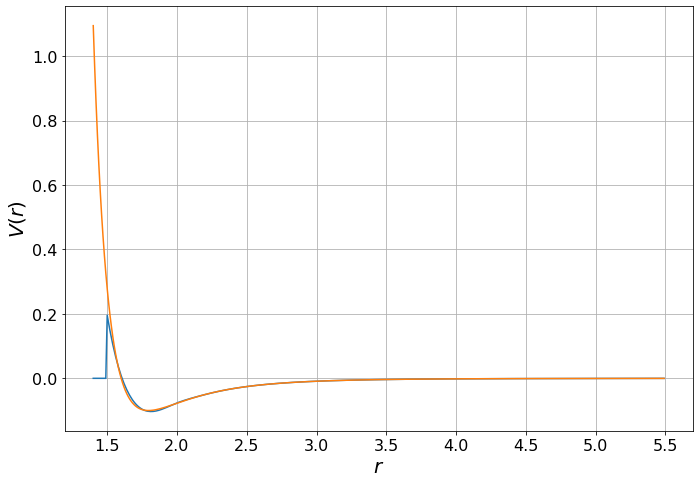

In [16]:
drs = jnp.arange(1.4,5.5,0.01)

print(f"Total error on the energies within the knot range: {error(c, drs)}")

U = uf2(drs, c)
plt.plot(drs,U)
U = lennard_jones(drs, sigma=1.6, epsilon=0.1)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()

### Data efficiency

In [17]:
loss = jit(grad(error))
error = jit(error)

def error_after_training(training_set, iterations, reference):
  c = jnp.zeros_like(coefficients)
  out = []
  for data in training_set:
    for i in range(iterations):
      dc = loss(c, data)
      c -= dc
    out.append(error(c, reference))
  return out

In [18]:
training_sets = []
X = [1,5,10,20,50,100,250,500,1000,5000]

rng = onp.random.default_rng(12345)

for i in X:
  tmp = jnp.asarray(rng.uniform(1.5,5.5,i))
  training_sets.append(jnp.sort(tmp))

print(training_sets[1])

[2.76703336 2.83125571 3.0644382  4.20501868 4.68946183]


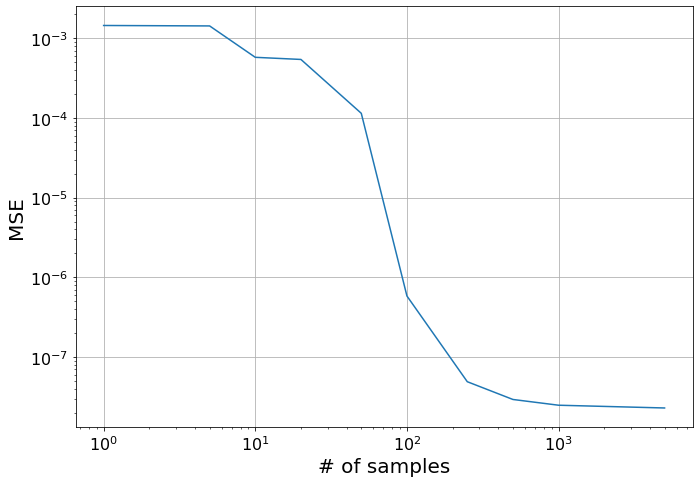

In [19]:
fine_sampling = jnp.arange(1.5,5.5,0.001) # 4000 data points with uniform spacing
reference = fine_sampling
# reference = training_sets[-1]
n_steps = 200 # number of steps in the gradient descent

U = error_after_training(training_sets, n_steps, reference)
plt.loglog(X,U)
format_plot("# of samples", "MSE")
finalize_plot()